<a href="https://colab.research.google.com/github/mariabandeira/Reconhecimento-de-Digitos/blob/main/MiniProjeto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de Dígitos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# caminho dos arquivos CSV
file_train = 'https://raw.githubusercontent.com/mariabandeira/Reconhecimento-de-Digitos/main/dataset_digits/train.csv'
file_test = 'https://raw.githubusercontent.com/mariabandeira/Reconhecimento-de-Digitos/main/dataset_digits/test.csv'

# Lendo o CSV
X_train = pd.read_csv(file_train, sep=';')
X_test = pd.read_csv(file_test, sep=';')

# Exibindo as primeiras linhas dos DataFrames
print(X_train.head())
print(X_test.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      0       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      0       0       0       0       0       0       0       0       0   
3      0       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 13.1 MB


In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 6.7 MB


In [5]:
X_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,2186.000000,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,...,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0,2186.0
mean,2.651418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.015090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_test.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,1115.000000,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,...,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0
mean,2.693274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.010542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train['label'].value_counts()

,count
label,
1,608
4,577
5,576
0,425


# 3.1 Redução da dimensão das amostras

In [8]:
# Intensidade da imagem

def intensidade(X):
  I = []
  for i in range(len(X)):
    sumpixel = X.iloc[i].sum() - X['label'][i]
    I.append(sumpixel / 255)
  return I

I_train = intensidade(X_train)
I_test = intensidade(X_test)

In [9]:
# Simetria da Imagem: Sv + Sh

def simetria(X):
  # 1. Simetria Vertical
  Sv_list = []
  for img in range(len(X)):
    sumv = 0
    for i in range(28):
      for j in range(14):
        xi = i * 28 + j
        xj = i * 28 + (27 - j)
        sumv += abs(X.iloc[img, xi+1] - X.iloc[img, xj+1])
    Sv_list.append(sumv / 255)

  # 2. Simetria Horizontal
  Sh_list = []
  for img in range(len(X)):
    sumh = 0
    for j in range(28):
      for i in range(14):
        xi = i * 28 + j
        xj = (27 - i) * 28 + j
        sumh += abs(X.iloc[img, xi+1] - X.iloc[img, xj+1])
    Sh_list.append(sumh / 255)

  Si_list = [sv + sh for sv, sh in zip(Sv_list, Sh_list)]
  return Si_list

Si_train = simetria(X_train)
Si_test = simetria(X_test)

In [10]:
# o dataset train_redu irá conter apenas as colunas label, I_list e Si_list
train_redu = pd.DataFrame({'label': X_train['label'], 'intensidade': I_train, 'simetria': Si_train})
print(train_redu.head())

test_redu = pd.DataFrame({'label': X_test['label'], 'intensidade': I_test, 'simetria': Si_test})
print(test_redu.head())

   label  intensidade    simetria
0      0   145.435294  148.572549
1      0   118.576471  137.113725
2      0   127.600000  134.047059
3      0   138.047059  151.003922
4      0   146.215686  122.501961
   label  intensidade    simetria
0      0   147.933333  130.470588
1      0   131.054902  122.721569
2      0   134.890196  151.725490
3      0   139.976471  133.921569
4      0   129.580392  130.274510


In [11]:
train_redu.to_csv('dataset_redu/train_redu.csv', index=False, sep=';')
test_redu.to_csv('dataset_redu/test_redu.csv', index=False, sep=';')

# 3.2 Classificação dos dígitos 1x5

## Filtragem dos dados

In [12]:
train1x5 = train_redu[train_redu['label'].isin([1, 5])]
test1x5 = test_redu[test_redu['label'].isin([1, 5])]

In [13]:
print(train1x5['label'].value_counts())
print(test1x5['label'].value_counts())

label
1    608
5    576
Name: count, dtype: int64
label
1    292
5    291
Name: count, dtype: int64


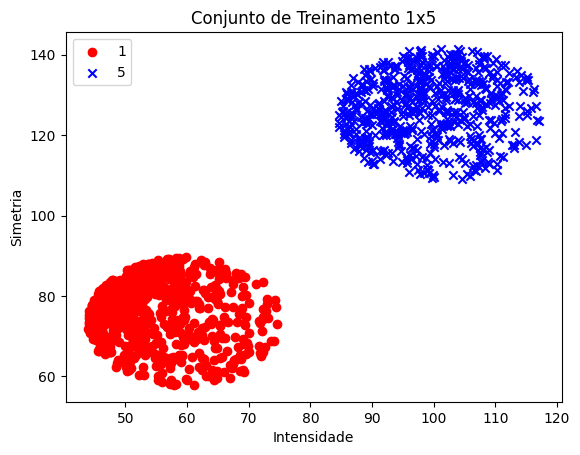

In [14]:
plt.scatter(train1x5[train1x5['label'] == 1]['intensidade'],
            train1x5[train1x5['label'] == 1]['simetria'],
            c='red', marker='o', label='1')  # Círculos azuis para a categoria 1

plt.scatter(train1x5[train1x5['label'] == 5]['intensidade'],
            train1x5[train1x5['label'] == 5]['simetria'],
            c='blue', marker='x', label='5')  # Triângulos vermelhos para a categoria 5

plt.title('Conjunto de Treinamento 1x5')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')

plt.legend()

plt.show()

In [15]:
train1x5.reset_index(drop=True, inplace=True)
train1x5.head()

,label,intensidade,simetria
0,1,44.701961,69.270588
1,1,59.850980,83.443137
2,1,48.552941,79.043137
3,1,69.435294,72.878431
4,1,51.541176,84.611765


In [16]:
test1x5.reset_index(drop=True, inplace=True)
test1x5.head()

,label,intensidade,simetria
0,1,51.639216,71.443137
1,1,51.674510,85.050980
2,1,44.847059,72.674510
3,1,50.760784,81.945098
4,1,57.788235,72.564706


In [17]:
X_train1x5 = train1x5[['intensidade', 'simetria']].values
y_train1x5 = np.array([1 if y_ == 1 else -1 for y_ in train1x5['label']])

In [18]:
X_test1x5 = test1x5[['intensidade', 'simetria']].values
y_test1x5 = np.array([1 if y_ == 1 else -1 for y_ in test1x5['label']]) # OBS: no pdf ele diz que o y é apenas o label

In [19]:
def pred_digito(y):
  y = np.where(y == 1, 1, 5)
  return y

## Regressão Linear

In [20]:
class LinearRegression:
  def __init__(self):
    self.w = None

  def fit(self, _X, _y):
    N = len(_X)

    X = np.column_stack((np.ones((N, 1)), _X))

    xtx = X.T @ X
    inv = np.linalg.inv(xtx) @ X.T
    self.w = inv @ _y

  def predict(self, _x):
    X = np.column_stack((np.ones((len(_x), 1)), _x))
    return [np.dot(self.w, xn) for xn in X]

  def getW(self):
    return self.w

In [21]:
class LRClassifier():
  def execute(self, _X, _y):
    lr = LinearRegression()
    lr.fit(_X, _y)
    self.w = lr.getW()

  def predict(self, X):
    N = len(X)
    X = np.column_stack((np.ones((N, 1)), X))
    return [np.sign(np.dot(self.w, xn)) for xn in X]

  def getRegressionY(self, regressionX, shift=0):
    return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

### Treino

In [22]:
classifier = LRClassifier()
classifier.execute(X_train1x5, y_train1x5)

predictions = classifier.predict(X_train1x5)

In [23]:
# Predição do Dígito com LRClassifier
pred = np.array(predictions)
pred = pred_digito(pred)
pred

array([1, 1, 1, ..., 5, 5, 5])

In [24]:
lr = LinearRegression()
lr.fit(X_train1x5, y_train1x5)
y_pred = np.array(lr.predict(X_train1x5))
w = lr.getW()
print(w)

[ 3.58751288 -0.01875499 -0.02111635]


In [25]:
# Predição do Dígito com LinearRegression
y_pred = np.where(y_pred >= 0, 1, -1)
y_pred = pred_digito(y_pred)
y_pred

array([1, 1, 1, ..., 5, 5, 5])

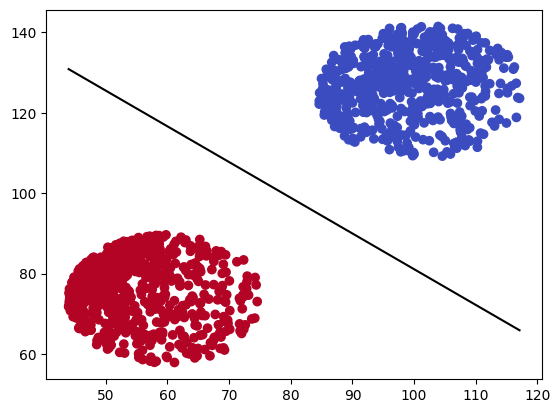

In [26]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_train1x5[:, 0], X_train1x5[:, 1], c=y_train1x5, cmap='coolwarm')
x = np.linspace(X_train1x5[:, 0].min(), X_train1x5[:, 0].max(), 100)
y = classifier.getRegressionY(x)
plt.plot(x, y, color='black')
plt.show()

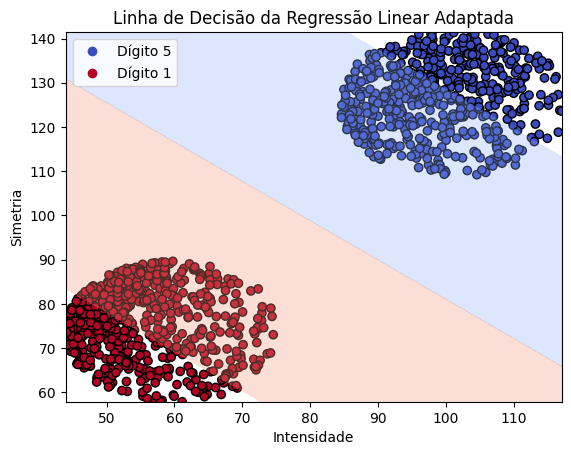

In [27]:
# Plotar os dados e a linha de decisão com LinearRegression
plt.figure()
scatter = plt.scatter(X_train1x5[:, 0], X_train1x5[:, 1], c=y_train1x5, cmap='coolwarm', marker='o', edgecolor='k')

xx, yy = np.meshgrid(np.linspace(X_train1x5[:, 0].min(), X_train1x5[:, 0].max(), 500),
                     np.linspace(X_train1x5[:, 1].min(), X_train1x5[:, 1].max(), 500))
Z = np.array(lr.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm', levels=[-1, 0, 1])
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Linha de Decisão da Regressão Linear Adaptada')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Dígito 5', 'Dígito 1'])
plt.show()


### Teste

In [28]:
predictions_test = classifier.predict(X_test1x5)
pred_test = np.array(predictions_test)
pred_test = pred_digito(pred_test)
pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5,

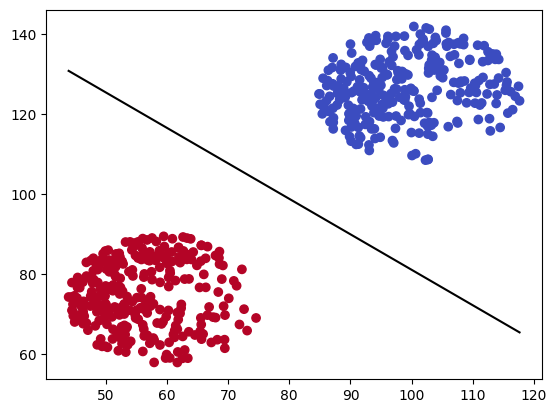

In [29]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_test1x5[:, 0], X_test1x5[:, 1], c=y_test1x5, cmap='coolwarm')
x = np.linspace(X_test1x5[:, 0].min(), X_test1x5[:, 0].max(), 100)
y = classifier.getRegressionY(x)
plt.plot(x, y, color='black')
plt.show()

## Perceptron

In [30]:
class PocketPLA():
  def __init__(self):
    self.w = None

  def get_w(self):
    return self.w

  def set_w(self, w):
    self.w = w

  def execute(self, _X, y):
    X = np.array(_X)
    hasWrongClassifiedPoint = True
    bestError = len(y)

    lr = LinearRegression()
    lr.fit(_X[:, 1:], y)
    self.w = np.array(lr.getW())

    #self.w = np.zeros(len(X[0]))
    bestW = self.w
    for iter in range(1000):

      #Testa se sign(wTXn) != Yn - ponto classificado errado
      for i in range(len(y)):
        if(np.sign(np.dot(self.w, X[i])) != y[i]):
          self.w = self.w + (y[i]*X[i])
          eIN = self.errorIN(X, y)
          if(bestError > eIN):
            bestError = eIN
            bestW = self.w
    self.w = bestW

  def getOriginalY(self, originalX):
    return (-self.w[0] - self.w[1]*originalX) / self.w[2]

  def h(self, x):
    return np.sign(np.dot(self.w, x))

  def errorIN(self, X, y):
    error = 0
    for i in range(len(y)):
      if(np.sign(np.dot(self.w, X[i])) != y[i]):
        error += 1

    return error

###  Treino

In [31]:
X_train1x5 = np.hstack((np.ones((len(X_train1x5), 1)), X_train1x5))

In [32]:
pla = PocketPLA()
pla.execute(X_train1x5, y_train1x5)

In [33]:
# Predição do Dígito com Pocket PLA
y_pla = []
for i in range(len(X_train1x5)):
  y_pla.append(pla.h(X_train1x5[i]))

y_pred_pla = pred_digito(np.array(y_pla))
y_pred_pla

array([1, 1, 1, ..., 5, 5, 5])

In [64]:
xmin = X_train1x5[:,1].min()
xmax = X_train1x5[:,1].max()
print(xmin, xmax)

43.97254901960784 117.10196078431373


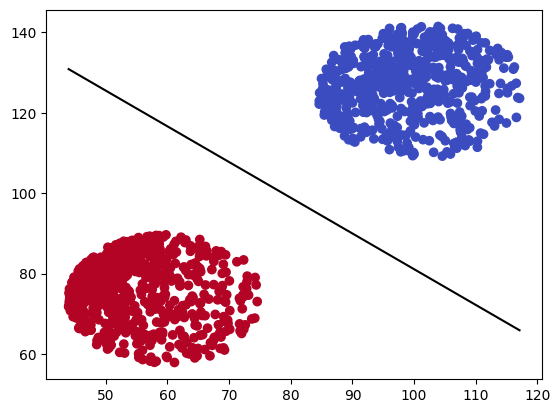

In [35]:
# Plotagem do resultado para o Pocket PLA
plt.scatter(X_train1x5[:, 1], X_train1x5[:, 2], c=y_train1x5, cmap='coolwarm')
x = np.linspace(xmin, xmax, 100)
y = pla.getOriginalY(x)
plt.plot(x, y, color='black')
plt.show()

In [36]:
pla.get_w()

array([ 3.58751288, -0.01875499, -0.02111635])

### Teste

In [37]:
X_test1x5 = np.hstack((np.ones((len(X_test1x5), 1)), X_test1x5))

In [38]:
# Predição do Dígito com Pocket PLA
pla_test = []
for i in range(len(X_test1x5)):
  pla_test.append(pla.h(X_test1x5[i]))

pred_pla_test = pred_digito(np.array(pla_test))
pred_pla_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5,

43.92549019607843 117.63921568627451


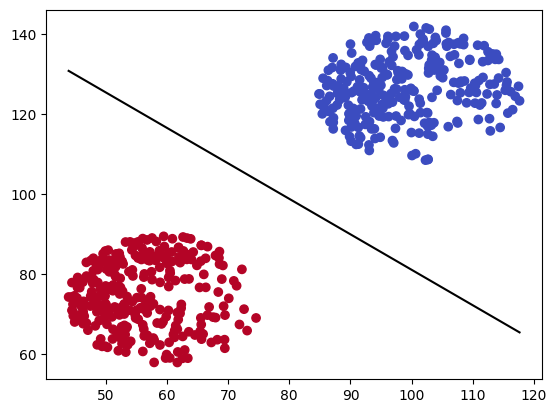

In [63]:
xmin_test = X_test1x5[:,1].min()
xmax_test = X_test1x5[:,1].max()
print(xmin_test, xmax_test)

# Plotagem do resultado para o Pocket PLA
plt.scatter(X_test1x5[:, 1], X_test1x5[:, 2], c=y_test1x5, cmap='coolwarm')
x = np.linspace(xmin_test, xmax_test, 100)
y = pla.getOriginalY(x)
plt.plot(x, y, color='black')
plt.show()

### Métricas de Aprendizado

In [41]:
#Computando o erro dentro da amostra (Ein)
N_in = len(y_train1x5)
eIn = 0
for i in range(N_in):
    if(y_pla[i] != y_train1x5[i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))

#Computando o erro dentro da amostra (Eout)
N_out = len(y_test1x5)
eOut = 0
for i in range(N_out):
    if(pla_test[i] != y_test1x5[i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.0
Eout = 0.0


In [42]:
print(classification_report(y_train1x5.tolist(), y_pla))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       576
           1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



## Regressão Logística

In [57]:
import numpy as np
from numpy import linalg as LA
import random
from random import sample

class LogisticRegression_:
  def __init__(self, eta=0.1, tmax=1000, bs=1000000):
    self.eta = eta
    self.tmax = tmax
    self.batch_size = bs

  # Infere o vetor w da funçao hipotese
  #Executa a minimizao do erro de entropia cruzada pelo algoritmo gradiente de descida
  def fit(self, _X, _y):
    X = np.array(_X)
    y = np.array(_y)

    N = X.shape[0]
    d = X.shape[1]
    self.w = np.zeros(d)

    for t in range(self.tmax):
      #grad_t = -1 / N * np.sum((_y @ _X) / (1 + np.exp(_y @ w @ t @ _X)))
      grad_t = (1 / N) * X.T.dot(self.predict_prob(X) - y)

      if LA.norm(grad_t) < 1e-3:
        break

      self.w -= self.eta * grad_t

    self.w = w

  #funcao hipotese inferida pela regressa logistica
  def predict_prob(self, X):
    s = np.dot(X, self.w)
    prob = np.exp(s) / (1 + np.exp(s))
    return prob

  #Predicao por classificação linear
  def predict(self, X):
    prob = self.predict_prob(X)
    y = np.where(prob >= 0.5, 1, 0)
    return y

  def getW(self):
    return self.w

  def getRegressionY(self, regressionX, shift=0):
    return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

### Treino

In [58]:
LR = LogisticRegression_()
LR.fit(X_train1x5, y_train1x5)
pred_logistic = LR.predict_prob(X_train1x5)
pred_logistic

array([0.78353483, 0.66885115, 0.73258941, ..., 0.21449646, 0.25632801,
       0.21499347])

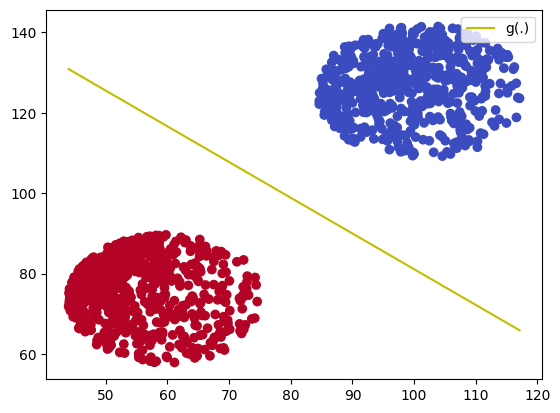

In [66]:
#desenha a reta inferida pela regressao logistica
xRL = [xmin, xmax]
yRL = [classifier.getRegressionY(xRL[0]), classifier.getRegressionY(xRL[1])]
plt.scatter(X_train1x5[:, 1], X_train1x5[:, 2], c=y_train1x5, cmap='coolwarm')
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')
plt.show()

### Teste

In [ ]:
pred_logistic_test = LR.predict_prob(X_test1x5)
pred_logistic_test

In [71]:
digits_logistic_test = pred_digito(LR.predict(X_test1x5))

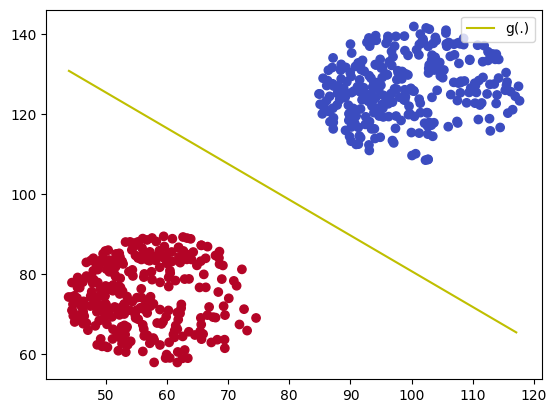

In [67]:
#desenha a reta inferida pela regressao logistica
yRL = [classifier.getRegressionY(xmin_test), classifier.getRegressionY(xmax_test)]
plt.scatter(X_test1x5[:, 1], X_test1x5[:, 2], c=y_test1x5, cmap='coolwarm')
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# 3.3. Classificador de dígitos completo